# Conservative Q-learning

Conservative Q-learning (CQL) is an offline RL algorithm that aims at solving the distributional shift induced by out-of-distribution actions. To do so, CQL applies a penalty term on the Q-values, to avoid overestimation on unseen actions.
In this notebook, we will implement a Soft Actor-Critic-based Conservative Q-Learning algorithm to solve a simple Hopper environment.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Tuple, Optional

import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from IPython.display import Image
from src.utils import (
    get_device,
    set_seed,
    eval_policy,
    demo_policy,
    plot_returns,
    save_frames_as_gif,
    return_range
)
from tqdm import tqdm
import einops
import os
import copy

from src.d4rl_dataset import D4RLSampler

plt.ion()

/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


Offline RL algorithms aim at training an optimal policy from pre-collected data. As such, we need to import this training data that will be used with CQL.
For that purpose, we start by importing D4RL, a library that contains training data obtained by running policies of different levels on a few environments. More information about D4RL can be found [in the original paper.](https://arxiv.org/abs/2004.07219).

In [2]:
import gym
import d4rl

/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
No module named 'flow'
/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:45:17


In this notebook, we will be solving the Hopper MuJoCo environment. The objective is to control a one-legged by apply a torque on three articulated joints, to make the figure stand and advance forward without falling. The action space is continuous and has dimension 3. In the next cell, we create this environment using the *medium replay* training data from D4RL. This data was collected from the replay buffer of a SAC policy trained up to a medium level of performance. For reproducibility, we also set the seed to a fixed value.

In [3]:
SEED: int = 42
ENVIRONMENT_NAME: str='hopper-medium-replay-v2'

# torch related defaults
DEVICE = get_device()
torch.set_default_dtype(torch.float32)

# Use random seeds for reproducibility
set_seed(SEED)

# instantiate the environment
env = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
action_dimension = env.action_space.shape[0]
state_dimension = env.observation_space.shape[0]

logger.info(f'Action Dimension: {action_dimension}')
logger.info(f'Action High: {env.action_space.high}')
logger.info(f'Action Low: {env.action_space.low}')
logger.info(f'State Dimension: {state_dimension}')

2024-12-11 17:06:21.868 | INFO     | src.utils:get_device:52 - Using cuda device.
2024-12-11 17:06:21.872 | INFO     | src.utils:set_seed:38 - Random seed set as 42.
/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
2024-12-11 17:06:21.880 | INFO     | __main__:<module>:18 - Action Dimension: 3
2024-12-11 17:06:21.881 | INFO     | __main__:<module>:19 - Action High: [1. 1. 1.]
2024-12-11 17:06:21.881 | INFO     | __main__:<module>:20 - Action Low: [-1. -1. -1.]
2024-12-11 17:06:21.882 | INFO     | __main__:<module>:21 - State Dimension: 11


Then, we need to download the training data for this environment, using the D4RL library. For convenience, we create a sampler that returns the training data in batches of size 256, which will be used during the training (this function was borrowed from HW2 for convenience).

In [4]:
dataset = d4rl.qlearning_dataset(env)

logger.info(f'Dataset type: {type(dataset)}')
logger.info(f'Dataset keys: {dataset.keys()}')
logger.info(f'# Samples: {len(dataset["observations"])}')
sampler = D4RLSampler(dataset, 256, DEVICE)

load datafile: 100%|██████████| 11/11 [00:00<00:00, 21.83it/s]
2024-12-11 17:06:24.699 | INFO     | __main__:<module>:3 - Dataset type: <class 'dict'>
2024-12-11 17:06:24.699 | INFO     | __main__:<module>:4 - Dataset keys: dict_keys(['observations', 'actions', 'next_observations', 'rewards', 'terminals'])
2024-12-11 17:06:24.700 | INFO     | __main__:<module>:5 - # Samples: 401598


As a Q-learning algorithm, CQL tries to fit a Q function to estimate the value of state-action pairs. Therefore, we need to define a Q-network that will be used to fit this function. In order to prevent overestimation of the state-action values, we use a double Q-network in this notebook, as described in the original paper's Appendix section. This network is defined below.

In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_dimension, action_dimension, hidden_dim, n_hidden):
        super(QNetwork, self).__init__()

        # Q1 architecture
        self.Q1 = nn.Sequential(
            nn.Linear(state_dimension+action_dimension,hidden_dim),
            nn.ReLU(),
            *nn.ModuleList([nn.Linear(hidden_dim,hidden_dim),nn.ReLU()]*n_hidden),
            nn.Linear(hidden_dim,1)
        )
       
        # Q2 architecture
        self.Q2 = nn.Sequential(
            nn.Linear(state_dimension+action_dimension,hidden_dim),
            nn.ReLU(),
            *nn.ModuleList([nn.Linear(hidden_dim,hidden_dim),nn.ReLU()]*n_hidden),
            nn.Linear(hidden_dim,1)
        )


    def forward(self, state, action):
        xu = torch.cat([state, action], -1)
        q1 = self.Q1(xu)
        q2 = self.Q2(xu)
        return q1, q2
    
hidden_dim: int = 256
n_hidden: int = 2
lr: float = 3e-4

q_critic = QNetwork(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
q_critic_target = copy.deepcopy(q_critic)
q_critic_target.requires_grad_(False)
q_optimizer = Adam(q_critic.parameters(), lr)

The main contribution of CQL resides in the penalty term added to the Q-function loss, which prevents overestimation on *out-of-distribution* actions. In addition to the traditional **TD error**, CQL introduces an additional penalty term to the loss function. For the specific SAC-CQL instance, this term is expressed as follows:

$$
\alpha \mathbb{E}_{s \sim \mathcal{D}} \left[ \log \sum_a \exp(Q(s, a)) - \mathbb{E}_{a \sim \hat{\pi}_\beta(a|s)} [Q(s, a)] \right] 
$$

By minimizing the difference between soft maximum (*logsum*) of the Q-function and the expected Q-values under the dataset's policy, this penalty term effectively reduce the overestimation bias induced by out-of-distribution actions.
This penalty is added to the traditional Bellman error to obtain the CQL objective:

$$
\min_Q \alpha \mathbb{E}_{s \sim \mathcal{D}} \left[ \log \sum_a \exp(Q(s, a)) - \mathbb{E}_{a \sim \hat{\pi}_\beta(a|s)} [Q(s, a)] \right] 
+ \frac{1}{2} \mathbb{E}_{s, a, s' \sim \mathcal{D}} \left[ \left( Q - \hat{\mathcal{B}}^\pi \hat{Q}^k \right)^2 \right]
$$


To approximate the soft maximum in the case of continuous actions, the original CQL paper proposes to use importance sampling. $N = 10$ actions are sampled from a uniform distribution, and $N$ actions are sampled from the current policy. Then, importance sampling is applied on these samples to estimate the log-sum-exp:

$$
\begin{align}
\log \sum_a \exp(Q(s, a)) &= \log \left( \frac{1}{2} \sum_a \exp(Q(s, a)) + \frac{1}{2} \sum_a \exp(Q(s, a)) \right) \\
&= \log \left( \frac{1}{2} \mathbb{E}_{a \sim \text{Unif}(a)} \left[ \frac{\exp(Q(s, a))}{\text{Unif}(a)} \right] 
+ \frac{1}{2} \mathbb{E}_{a \sim \pi(a|s)} \left[ \frac{\exp(Q(s, a))}{\pi(a|s)} \right] \right) \\
&\approx \log \left( \frac{1}{2N} \sum_{a_i \sim \text{Unif}(a)} \left[ \frac{\exp(Q(s, a_i))}{\text{Unif}(a)} \right] 
+ \frac{1}{2N} \sum_{a_i \sim \pi(a|s)} \left[ \frac{\exp(Q(s, a_i))}{\pi(a_i|s)} \right] \right)
\end{align}
$$

In the next cell, we implement the CQL loss to use during the training. Since we are implementing CQL on top of a SAC algorithm, we also include the entropy term to the TD error (cf [SAC](https://arxiv.org/abs/1801.01290) and HW1 for more details on SAC). Note that the CQL loss needs to be calculated for both Q-networks.

In [6]:
################################## Hyper-parameters Tuning ##################################
gamma = 0.99
alpha0 = 4
#############################################################################################


def optimize_phi(states, actions, rewards, next_states, not_dones):
    """
    Performs a gradient step on the Q-network.
    
    Args:
        states, actions, rewards, next_states, not_dones: batch of training data used to update Q
        
    Returns:
        q_loss: the total SAC-CQL loss
    """
    
    
    ############################### Bellman Error ###############################
    
    # Compute current Q-values (Q1 and Q2)
    q1_values, q2_values = q_critic(states, actions) 

    # Compute target Q-values (Q1 and Q2)
    with torch.no_grad():
        next_actions, log_probs,_ = cql_policy.sample(next_states) 
        q1_next, q2_next = q_critic_target(next_states, next_actions)  
        target_q_values = torch.min(q1_next, q2_next) 
        targets = rewards + gamma * not_dones * (target_q_values-alpha*log_probs.unsqueeze(-1))

    # TD loss for Q1 and Q2
    td_loss_q1 = F.mse_loss(q1_values, targets)
    td_loss_q2 = F.mse_loss(q2_values, targets)
    td_loss = td_loss_q1 + td_loss_q2
    ############################### End - Bellman Error ##############################
    
    ############################### CQL Penalty ################################
    
    N = 10  # Number of action samples (for each distribution: uniform/policy)
    with torch.no_grad():
        # Sample actions uniformly at random
        uniform_actions = torch.rand((states.size(0), N, actions.size(-1))).to(DEVICE)*2-1 #rescale to be between -1 & 1
        q1_uniform, q2_uniform = q_critic(states.unsqueeze(1).repeat(1, N, 1), uniform_actions)

        # Sample actions from the policy
        policy_actions = cql_policy.pi(states).sample((N,)).transpose(0, 1).to(DEVICE)
        q1_policy, q2_policy = q_critic(states.unsqueeze(1).repeat(1, N, 1), policy_actions)
        
        # Approximate logsumexp using importance sampling
        logsumexp_uniform1 = torch.logsumexp(q1_uniform, dim=1) / 2.0
        logsumexp_uniform2 = torch.logsumexp(q2_uniform, dim=1) / 2.0
        
        logsumexp_policy1 = torch.logsumexp(q1_policy, dim=1) / 2.0
        logsumexp_policy2 = torch.logsumexp(q2_policy, dim=1) / 2.0

        logsumexp_q1 = torch.mean(logsumexp_uniform1 + logsumexp_policy1)
        logsumexp_q2 = torch.mean(logsumexp_uniform2 + logsumexp_policy2)
        
    dataset_q1, dataset_q2 = q_critic(states, actions) 

    cql_loss1 = alpha0 * (logsumexp_q1 - dataset_q1)
    cql_loss2 = alpha0 * (logsumexp_q2 - dataset_q2)
    cql_loss = cql_loss1.mean()+cql_loss2.mean()
    
    # Total loss (both networks)
    q_loss = td_loss + cql_loss
    
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()

    return q_loss
        

The next step is to build the policy network. Here, there is no modification to the Gaussian policy network used in Soft Actor-Critic. Actions are scaled to stay within the environment's action space, and we use the reparametrization trick to enable backpropagation through action sampling. This network is defined below (similar to HW1).

In [7]:
from torch.distributions.normal import Normal

DEVICE = get_device()
HIDDEN_DIMENSION: int = 256
N_HIDDEN: int = 2
epsilon = 1e-6

def tensor(x: np.array, type=torch.float32, device=DEVICE) -> torch.Tensor:
    """
    Useful function to convert arrays to torch tensors
    """
    return torch.as_tensor(x, dtype=type, device=device)


def network(
        in_dimension: int, 
        out_dimension: int, 
        hidden_dimension: int = 256, 
        n_hidden: int = 3) -> nn.Module:
    """
    Args:
        in_dimension (int): Dimension of the input layer.
        hidden_dimension (int): Dimension of the hidden layers.
        out_dimension (int): Dimension of the output layer.

    Returns:
        nn.Module: The constructed neural network model.
    """
    shapes = [in_dimension] + [hidden_dimension] * n_hidden + [out_dimension]
    layers = []
    for i in range(len(shapes) - 2):
        layers.append(nn.Linear(shapes[i], shapes[i+1]))
        layers.append(nn.Mish())
    layers.append(nn.Linear(shapes[-2], shapes[-1]))
    return nn.Sequential(*layers)


class GaussianPolicy(nn.Module):
    def __init__(
            self,
            state_dimension: int,
            action_dimension: int,
            hidden_dimension: int = HIDDEN_DIMENSION,
            n_hidden: int = N_HIDDEN,
            action_space=None
    ):
        super(GaussianPolicy, self).__init__()
        self.network = network(
            state_dimension, 2 * action_dimension, hidden_dimension, n_hidden
        )
        self.action_dimension = action_dimension
        if action_space != None:
            #reshape the actions
            self.action_scale = tensor((action_space.high-action_space.low)/2)
            self.action_bias = tensor((action_space.high+action_space.low)/2)

    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the Policy network. Returns mean and log_std of the policy distribution

        Args:
            state (np.ndarray): The input state.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The tuple (mean, log_std) of the distribution corresponding to each action
        """
        out = self.network(state)
        mean, log_std = torch.split(out, self.action_dimension, dim=-1)
        log_std = torch.clamp(log_std, -10, 2)
        return mean, log_std
        

    def pi(self, state: torch.Tensor) -> Normal:
        """
        Computes the action distribution π(a|s) for a given state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            Categorical: The action distribution.
        """
        mean, log_std = self(state)
        std = log_std.exp()
        return Normal(mean, std)

    def action(self, state: np.ndarray, eval=False) -> np.ndarray:
        """
        Selects an action based on the policy without returning the log probability.

        Args:
            state (np.ndarray): The input state.

        Returns:
            torch.Tensor: The selected action.
        """
        state = tensor(state)

        policy = self.pi(state)
        if eval:
            action = policy.mean.cpu().numpy()
        else:
            action = policy.sample().cpu().numpy()
        return action

    def sample(self, states):
        """
        Samples actions for each state, using the reparametrization trick.
        
        Args:
            states: Batch of input states
            
        Returns:
            actions: actions sampled using the reparametrization trick
            log_prob: the log-probability of the action sampled for each state
            mean: the mean returned by the NN
        """
        mean, log_std = self.forward(states)
        std = log_std.exp()
        normal = Normal(0, 1)

        # Sample a batch of z values for all states
        z = normal.sample(mean.shape).to(DEVICE)  # Shape: (batch_size, action_dim)

        # Compute actions and log probabilities in batch
        actions = torch.tanh(mean + std * z)
        log_probs = Normal(mean, std).log_prob(mean + std * z) - torch.log(1 - actions.pow(2) + 1e-6)

        # Scale and shift actions
        actions = actions * self.action_scale + self.action_bias
        return actions, log_probs.sum(dim=-1), mean

cql_policy = GaussianPolicy(state_dimension, action_dimension, hidden_dim, n_hidden, env.action_space).to(DEVICE)
policy_optimizer = Adam(cql_policy.parameters(), lr=1e-4)

2024-12-11 17:06:26.242 | INFO     | src.utils:get_device:52 - Using cuda device.


Finally, we redefine the policy loss, which is identical to Soft Actor-Critic and aims at maximizing the Q-values, while maintaining a certain level of randomness, regulated via the entropy coefficient. The SAC policy objective is reminded below.

$$
J_\pi(\theta) = \mathbb{E}_{s \sim \mathcal{D}, a \sim \pi_\theta} 
\left[ \alpha \log \pi_\theta(a | s) - Q_\phi(s, a) \right]
$$

In [8]:
################################## Hyper-parameters Tuning ##################################
alpha = .2 #entropy coefficient
#############################################################################################

def optimize_theta(states):
    """
    Performs a gradient step on the policy.
    
    Args:
        states: batch of states from the training data 
    """
    actions, log_probs, _ = cql_policy.sample(states)

    Q_values = torch.amin(torch.cat(q_critic.forward(states,actions), 1),1).unsqueeze(-1)

    loss = -(Q_values-alpha*log_probs.unsqueeze(-1)).mean()
    
    policy_optimizer.zero_grad()
    loss.backward()
    policy_optimizer.step()
    
    return loss
    

Finally, the target network is updated using soft Polyak averaging update.

In [9]:
################################## Hyper-parameters Tuning ##################################
tau = 0.005
#############################################################################################


def update_target():
    """
    Performs a soft Polyak-averaging update of the target network.
    """
    for var, var_target in zip(q_critic.parameters(), q_critic_target.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

The following loop trains the value functions and policy networks using the D4RL training data using CQL. For each epoch, a gradient step is done on the 3 networks defined above for each batch of training data. The overall structure is similar to the SAC algorithm, the only difference resides in the Q-function loss calculation. We follow the recommendation from the original paper and normalize the reward based on the minimum and maximum observed trajectory rewards in the training data.

/scratch/1037284/ipykernel_2690696/402203127.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('cql_checkpoint.pth')


Resuming run from epoch 151


100%|██████████| 1569/1569 [00:15<00:00, 98.64it/s]
/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Epoch: 160. Q Loss: 82.8009. P Loss: -241.6008. Reward: 0.7838 +/- 0.0177


100%|██████████| 1569/1569 [00:16<00:00, 95.82it/s]


Epoch: 170. Q Loss: 77.9108. P Loss: -241.4759. Reward: 0.7594 +/- 0.0319


100%|██████████| 1569/1569 [00:15<00:00, 98.64it/s]


Epoch: 180. Q Loss: 78.7677. P Loss: -242.8929. Reward: 0.6377 +/- 0.2048


100%|██████████| 1569/1569 [00:15<00:00, 98.66it/s]


Epoch: 190. Q Loss: 78.5656. P Loss: -243.7632. Reward: 0.6656 +/- 0.2172


100%|██████████| 1569/1569 [00:16<00:00, 94.76it/s]


Epoch: 200. Q Loss: 74.7047. P Loss: -244.1566. Reward: 0.7551 +/- 0.1340


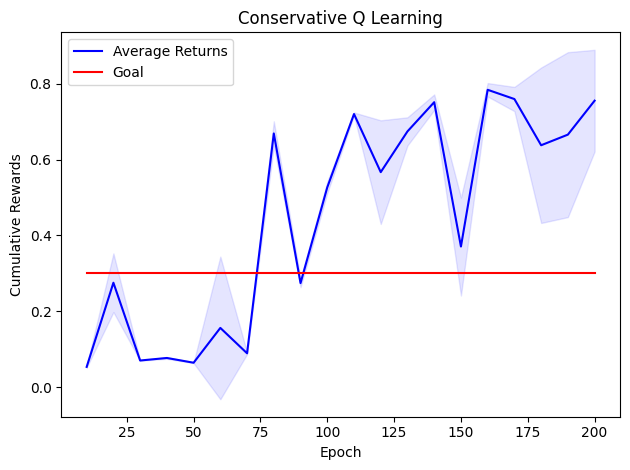

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
################################## Hyper-parameters Tuning ##################################
EPOCHS = 200
EVAL_FREQ = 10
LOAD_FROM_CKPT = True

min_rew, max_rew = return_range(dataset, 1000) #for reward normalization. Returns min/max trajectory reward 
#############################################################################################

policy_lr_schedule = CosineAnnealingLR(policy_optimizer, EPOCHS * len(sampler)) #similarly to what is done in the paper

means, stds, start_epoch = [], [], 0
if os.path.exists('cql_checkpoint.pth') and LOAD_FROM_CKPT: #to continue training from checkpoint
    checkpoint = torch.load('cql_checkpoint.pth')

    cql_policy.load_state_dict(checkpoint['cql_policy'])
    policy_optimizer.load_state_dict(checkpoint['policy_optimizer'])
    q_critic.load_state_dict(checkpoint['q_critic'])
    q_critic_target.load_state_dict(checkpoint['q_critic_target'])
    q_optimizer.load_state_dict(checkpoint['q_optimizer'])
    
    start_epoch = checkpoint['epoch']
    means = checkpoint['means']
    stds = checkpoint['stds']
    
    print(f'Resuming run from epoch {start_epoch}')

step = 0
for epoch in range(start_epoch, EPOCHS):
    total_q_loss = total_v_loss = total_policy_loss = count = 0
    policy_losses = []
    
    for batch in tqdm(sampler):
        ################# Gather batch data ##################
        state = batch['state'].to(DEVICE)
        next_state = batch['next_state'].to(DEVICE)
        action = batch['action'].to(DEVICE)
        reward = einops.rearrange(batch['reward'], 'b -> b 1').to(DEVICE)
        reward = reward / (max_rew - min_rew) * 1000
        not_done = einops.rearrange(batch['not_done'], 'b -> b 1').to(DEVICE)
        ######################################################
        
        ################### Update networks ##################
        #Update Q network
        target = reward+not_done*gamma
        q_loss = optimize_phi(state,action,reward,next_state,not_done)
        
        #Update target network
        update_target()
        
        #Update policy network
        
        policy_loss = optimize_theta(state)
        total_policy_loss += policy_loss.item()
        ######################################################
        
        #Record the losses throughout the training
        total_q_loss += q_loss.item()
        
        count += 1
        step += 1
    #Evaluation step
    if (epoch + 1) % EVAL_FREQ == 0:
        rew_mean, rew_std = eval_policy(cql_policy, environment_name=ENVIRONMENT_NAME, eval_episodes=50)
        print(f'Epoch: {epoch + 1}. Q Loss: {total_q_loss / count:.4f}. P Loss: {total_policy_loss / count:.4f}. Reward: {rew_mean:.4f} +/- {rew_std:.4f}')
        means.append(rew_mean)
        stds.append(rew_std)

    # Save a checkpoint so that we can resume training if it crashes
    checkpoint = {
        'cql_policy': cql_policy.state_dict(),
        'policy_optimizer': policy_optimizer.state_dict(),
        'q_critic': q_critic.state_dict(),
        'q_critic_target': q_critic_target.state_dict(),
        'q_optimizer': q_optimizer.state_dict(),
        'epoch': epoch + 1,
        'means': means,
        'stds': stds
    }
    torch.save(checkpoint, 'cql_checkpoint.pth')

epochs = np.arange(EVAL_FREQ, EPOCHS+1, step=EVAL_FREQ)
plot_returns(means, stds, 'Conservative Q Learning', goal=0.3, epochs=epochs)

Finally, we can visualize our trained policy! As you can see, CQL is able to learn an efficient policy in a completely offline approach. 

/scratch/1037284/ipykernel_2690696/3853992630.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cql_policy.load_state_dict(torch.load('cql_checkpoint.pth')['cql_policy'])


2654.123006559831


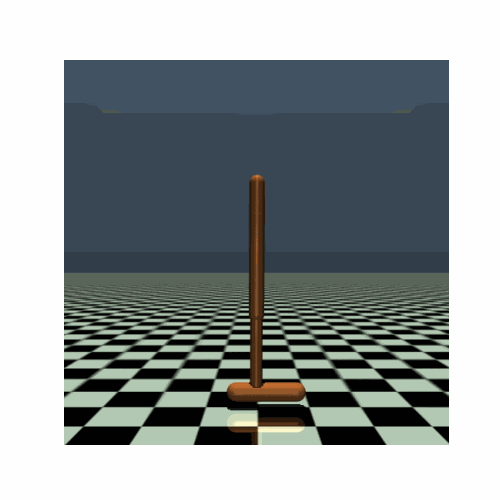

In [14]:
cql_policy.load_state_dict(torch.load('cql_checkpoint.pth')['cql_policy'])
frames, total_reward = demo_policy(cql_policy, environment_name=ENVIRONMENT_NAME, steps=1000)
print(total_reward)
gif_path = save_frames_as_gif(frames, method_name='cql')
Image(open(gif_path,'rb').read())

A GIF from our trained policy is presented below:

<img src="./artifacts/cql_policy.gif?v=3">